# Vegagreining á gervitunglamyndum (FRUMLÍKAN)
Nathan HK

In [1]:
import gc
from io import BytesIO
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import psutil
from pyrosm import OSM
from pyrosm import get_data
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import sklearn as sk
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import tracemalloc


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

AttributeError: _ARRAY_API not found

In [2]:
mappa = '/Users/002-nathan/Desktop/Envalys/gtm/'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina vegi á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar vega.
- **Gervitunglamyndir:** Við notum skjámyndatökur af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.
- **Staðsetningar vega:** Við notum OpenStreetMap.

Ég nota Apple M1 Pro-örgjörvi með 16 GB minni.

## Gervitunglamyndir
Við notum lista yfir greinar á ensku Wikipediunni um staði á Höfuðborgarsvæðinu og Akureyri. Gögnin á Landsbyggðinni eru ekki nóg nákvæm fyrir þetta líkan.

In [3]:
byrjun = time.time()
hnitlisti = []
hnit_sv = {'h':[(64.167, 64.073, -21.649992, -22.041892, 30, 40),
                (64.073, 64.033177, -21.871, -22.041892, 20, 20),
                (64.200015, 64.167, -21.649992, -21.763, 10, 10)],
           'a':[(65.706074, 65.656070, -18.073935, -18.148693, 10, 10)]}
for svk in hnit_sv:
    for hnit_h in hnit_sv[svk]:
        diff = (hnit_h[0] - hnit_h[1], hnit_h[2] - hnit_h[3])
        for i in range(hnit_h[4]):
            lat = round(hnit_h[1] + (i * 2 + 1) * diff[0] / 60, 6)
            for j in range(hnit_h[5]):
                lon = round(hnit_h[3] + (j * 2 + 1) * diff[1] / 60, 6)
                hnitlisti.append((svk, lat, lon))

for a in os.listdir(mappa):
    s = a.split('_')
    if len(s) != 3 or s[0] not in ['h', 'a', 'd'] or s[2][-4:] != '.png':
        continue
    tp = (s[0], float(s[1]), float(s[2][:-4]))
    if tp not in hnitlisti:
        hnitlisti.append(tp)
hnitlisti = hnitlisti[:2000]

print(len(hnitlisti))

2000


Við getum ekki tekið myndir af miðjunni skjásins, því það eru önnur HTML-efni sem hylja gervitunglamyndirnar. Þess vegna leitum við að staði sem eru 0.002° til austurs frá myndatökustaðnum; hérna eru hnitin á skjánum fyrir þennan stað.

In [4]:
skhn = (746, 861)

Við tökum skjámyndir af öllum stöðum á hnitlistanum.
- URL-ið notar ISN93-hnit, en okkar hnit eru WGS84, og það er engin einföld leið til að skipta milli þeirra. Þess vegna þurfum við að leita að hnitum eins og manneskja myndi leita.
- Á Chrome er myndasvæðið 512x512, en þegar myndin er vistuð verður hún 1024x1024.

In [5]:
byrjun = time.time()
f = False
for n in range(len(hnitlisti)):
    hnit = hnitlisti[n]
    try:
        z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
        z.close()
    except FileNotFoundError:
        f = True
        break
if f:
    driver = webdriver.Chrome()
    driver.set_window_size(1500, 1000)
    driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
    # Accept GDPR
    try:
        btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
        btn.click()
    except NoSuchElementException:
        pass
    # Allow cookies
    try:
        btn = driver.find_element(By.XPATH, '//button[@class="ch2-btn ch2-allow-all-btn ch2-btn-primary"]')
        btn.click()
    except NoSuchElementException:
        pass
    leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
    for n in range(len(hnitlisti)):
        if n % 100 == 0:
            print(n, time.time() - byrjun)
        hnit = hnitlisti[n]
        try:
            # Does file exist?
            z = open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png', 'rb')
            z.close()
        except FileNotFoundError:
            # Input search term into search box
            leit.clear()
            leit.send_keys(str(hnit[1]) + ', ' + str(hnit[2] + 0.002))
            leit.send_keys(Keys.RETURN)
            time.sleep(2) # Wait for images to load
            try:  # Place not found
                nf = driver.find_element(By.XPATH, '//div[@class="row not-found"]')
            except NoSuchElementException:  # Place found, save and crop screenshot
                driver.save_screenshot(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
                skmynd = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
                skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
                skmynd.save(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
            time.sleep(1)
    driver.close()
print(time.time() - byrjun)

0.09602499008178711


## Staðsetningar vega
Við sækjum gögn frá OpenStreetMap.

In [6]:
fp = get_data('Iceland')

Downloaded Protobuf data 'iceland-latest.osm.pbf' (58.67 MB) to:
'/var/folders/k7/ssgp6zcs72j0lsw27nm39kvw0000gn/T/pyrosm/iceland-latest.osm.pbf'


Þetta undirforrit tekur díl á myndinni og finnur GPS-hnitin. Við notum Web Mercator.

In [7]:
def pix2coord(pix, hnit_br):
    x_t = hnit_br[1] + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = hnit_br[0] + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

Þetta undirforrit tekur GPS-hnit og finnur dílinn á myndinni. Forritað með aðstoð frá o1-preview eftir OpenAI.

In [8]:
def coord2pix(lat, lon, hnit_br):
    # Convert degrees to radians
    lon_radians = math.radians(lon)
    lat_radians = math.radians(lat)
    
    # Invert the calculation for x_t
    x_t = ((lon_radians + math.pi) * (2 ** 17)) / (2 * math.pi)
    # Calculate pix[0] (x-coordinate)
    pix_x = (x_t - hnit_br[1]) * 1024 + 512
    
    # Invert the calculation for y_t
    b = lat_radians / 2 + math.pi / 4
    a = math.tan(b)
    c = math.pi - math.log(a)
    y_t = c * (2 ** 17) / (2 * math.pi)
    # Calculate pix[1] (y-coordinate)
    pix_y = (y_t - hnit_br[0]) * 1024 + 512
    
    return (pix_x, pix_y)

Við sækjum tvo lista: einn yfir vegi á Höfuðborgarsvæðinu, og einn á Akureyri.

In [9]:
byrjun = time.time()
veg_listi = {}
osm_h = OSM(fp, bounding_box=[-22.140901, 63.847886, -21.152576, 64.390306])
veg_listi['h'] = osm_h.get_network(network_type='driving')
osm_a = OSM(fp, bounding_box=[-18.398071, 65.543087, -17.968359, 66.576398])
veg_listi['a'] = osm_a.get_network(network_type='driving')
print(time.time() - byrjun)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


24.69309401512146


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


In [10]:
byrjun = time.time()
X_gogn = []
y_gogn = []
bd_all = {}
for st in ['h', 'a']:
    vegir = veg_listi[st]
    bd = []
    for k in range(vegir.shape[0]):
        bns = vegir['geometry'][k].bounds
        bd.append(bns)
    bd_all[st] = bd
for n in range(len(hnitlisti)):
    if n % 100 == 0:
        print(n, time.time() - byrjun)
    hnit = hnitlisti[n]
    
    # Open image
    try:
        gtm = Image.open(mappa + hnit[0] + '_' + str(hnit[1]) + '_' + str(hnit[2]) + '.png')
        dilar = gtm.load()
    except FileNotFoundError:
        continue
    except OSError:
        print('OSError', hnit)
        continue
    
    # Convert coordinates
    y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) - 0.5
    y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))) + 0.5
    if hnit[0] == 'd':
        vegir = veg_listi['h']
    else:
        vegir = veg_listi[hnit[0]]
    hnit_br = (1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[1]) / 2))),
               1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[2])))
    
    # Roads
    y_mynd = np.zeros((1, 1, 1024, 1024))
    if hnit[0] == 'd':
        bd = bd_all['h']
    else:
        bd = bd_all[hnit[0]]
    ermedvegi = [0, 0, 0, 0]
    for v in range(vegir.shape[0]):
        bns = bd[v]
        if bns[0] > hnit[2] + 0.0014 or bns[1] > hnit[1] + 0.0008 or bns[2] < hnit[2] - 0.0014 or bns[3] < hnit[1] - 0.0008:
            continue
        NW = coord2pix(bns[3], bns[0], hnit_br)
        SE = coord2pix(bns[1], bns[2], hnit_br)
        if NW[0] > 1024 or NW[1] > 1024 or SE[0] < 0 or SE[1] < 0:
            continue
        for p in vegir.loc[v, 'geometry'].geoms:
            x, y = p.xy
            if ermedvegi[0] == 1 and y[0] > hnit[1] and x[0] < hnit[2]:
                continue
            elif ermedvegi[1] == 1 and y[0] > hnit[1] and x[0] > hnit[2]:
                continue
            elif ermedvegi[2] == 1 and y[0] < hnit[1] and x[0] < hnit[2]:
                continue
            elif ermedvegi[3] == 1 and y[0] < hnit[1] and x[0] > hnit[2]:
                continue
            ct = coord2pix(y[0], x[0], hnit_br)
            if ct[0] >= 0 and ct[0] < 512 and ct[1] >= 0 and ct[1] < 512:
                ermedvegi[0] = 1
            elif ct[0] >= 512 and ct[0] < 1024 and ct[1] >= 0 and ct[1] < 512:
                ermedvegi[1] = 1
            elif ct[0] >= 0 and ct[0] < 512 and ct[1] >= 512 and ct[1] < 1024:
                ermedvegi[2] = 1
            elif ct[0] >= 512 and ct[0] < 1024 and ct[1] >= 512 and ct[1] < 1024:
                ermedvegi[3] = 1
        if sum(ermedvegi) == 4:
            break
    if hnit[0] != 'd':
        frummynd = np.array(gtm.getdata()).reshape(1024, 1024, 3)
        X_gogn.append(torch.tensor(np.transpose(frummynd[:512, :512, :], (2, 0, 1)).reshape(1, 3, 512, 512), 
                                   dtype=torch.float16).to(device))
        X_gogn.append(torch.tensor(np.transpose(frummynd[:512, 512:, :], (2, 0, 1)).reshape(1, 3, 512, 512), 
                                   dtype=torch.float16).to(device))
        X_gogn.append(torch.tensor(np.transpose(frummynd[512:, :512, :], (2, 0, 1)).reshape(1, 3, 512, 512), 
                                   dtype=torch.float16).to(device))
        X_gogn.append(torch.tensor(np.transpose(frummynd[512:, 512:, :], (2, 0, 1)).reshape(1, 3, 512, 512), 
                                   dtype=torch.float16).to(device))
        y_gogn.append(torch.tensor(np.array(ermedvegi[0]).reshape(1, 1), dtype=torch.float16).to(device))
        y_gogn.append(torch.tensor(np.array(ermedvegi[1]).reshape(1, 1), dtype=torch.float16).to(device))
        y_gogn.append(torch.tensor(np.array(ermedvegi[2]).reshape(1, 1), dtype=torch.float16).to(device))
        y_gogn.append(torch.tensor(np.array(ermedvegi[3]).reshape(1, 1), dtype=torch.float16).to(device))
    gtm.close()
print(time.time() - byrjun)

0 0.49468016624450684
100 33.57233500480652
200 63.40859293937683
300 89.38202381134033
400 115.46943998336792
500 141.21492195129395
600 166.99735808372498
700 192.9009931087494
800 218.51802015304565
900 244.102276802063
1000 270.31693291664124
1100 296.03365993499756
1200 321.61940717697144
1300 347.54485988616943
1400 373.3287317752838
1500 399.06639194488525
1600 424.54875898361206
1700 449.92046093940735
1800 475.32990312576294
1900 500.7698919773102
526.1604318618774


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_gogn, y_gogn)

## Líkan
Hérna er CNN.

Forritað með aðstoð frá o1-preview.

In [12]:
class VGLikan(nn.Module):
    def __init__(self):
        super(VGLikan, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, dtype=torch.float16)    # Output: 512x512x16
        self.pool = nn.MaxPool2d(2, 2)                                       # Output size halved
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, dtype=torch.float16)   # Output: 256x256x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, dtype=torch.float16)   # Output: 128x128x64
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, dtype=torch.float16)  # Output: 64x64x128
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, dtype=torch.float16) # Output: 32x32x256
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, dtype=torch.float16) # Output: 16x16x512
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dtype=torch.float16) # Output: 8x8x512
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, dtype=torch.float16) # Output: 4x4x512

        # Fully connected layers
        self.fc1 = nn.Linear(2 * 2 * 512, 512, dtype=torch.float16)
        self.fc2 = nn.Linear(512, 128, dtype=torch.float16)
        self.fc3 = nn.Linear(128, 1, dtype=torch.float16)  # Output layer for binary classification

    def forward(self, x):
        # Input x: (batch_size, 3, 1024, 1024)
        x = F.relu(self.conv1(x))  # Output: (batch_size, 16, 512, 512)
        x = self.pool(x)           # Output: (batch_size, 16, 256, 256)

        x = F.relu(self.conv2(x))  # Output: (batch_size, 32, 256, 256)
        x = self.pool(x)           # Output: (batch_size, 32, 128, 128)

        x = F.relu(self.conv3(x))  # Output: (batch_size, 64, 128, 128)
        x = self.pool(x)           # Output: (batch_size, 64, 64, 64)

        x = F.relu(self.conv4(x))  # Output: (batch_size, 128, 64, 64)
        x = self.pool(x)           # Output: (batch_size, 128, 32, 32)

        x = F.relu(self.conv5(x))  # Output: (batch_size, 256, 32, 32)
        x = self.pool(x)           # Output: (batch_size, 256, 16, 16)

        x = F.relu(self.conv6(x))  # Output: (batch_size, 512, 16, 16)
        x = self.pool(x)           # Output: (batch_size, 512, 8, 8)

        x = F.relu(self.conv7(x))  # Output: (batch_size, 512, 8, 8)
        x = self.pool(x)           # Output: (batch_size, 512, 4, 4)

        x = F.relu(self.conv8(x))  # Output: (batch_size, 512, 4, 4)
        x = self.pool(x)           # Output: (batch_size, 512, 2, 2)

        x = x.view(-1, 2 * 2 * 512)  # Flatten the tensor
        x = F.relu(self.fc1(x))      # Fully connected layer
        x = F.relu(self.fc2(x))      # Fully connected layer
        x = self.fc3(x)              # Output layer
        x = torch.sigmoid(x)         # Apply sigmoid activation for binary classification

        return x

In [13]:
epochs = 10

In [14]:
byrjun = time.time()
# Initialize model
likan = VGLikan().to(device)

# Define a loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(likan.parameters(), lr=1e-4)

train_loss = []
test_loss = []

for e in range(epochs):
    likan.eval()
    with torch.no_grad():
        rl = 0.0
        for i in range(len(X_train)):
            y_pred = likan(X_train[i])
            loss = criterion(y_pred, y_train[i])
            rl += loss.item()
        train_loss.append(rl / len(X_train))
        rl = 0.0
        for i in range(len(X_test)):
            y_pred = likan(X_test[i])
            loss = criterion(y_pred, y_test[i])
            rl += loss.item()
        test_loss.append(rl / len(X_test))
    torch.mps.empty_cache()
    
    likan.train()
    for i in range(len(X_train)):
        y_pred = likan(X_train[i])
        loss = criterion(y_pred, y_train[i])
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        torch.mps.synchronize()
        if i % 10 == 0:
            torch.mps.empty_cache()
        
    torch.mps.empty_cache()

    # Print loss for the current epoch
    print(f'Epoch [{e+1}/{epochs}], Time: {time.time() - byrjun}')

likan.eval()
with torch.no_grad():
    rl = 0.0
    for i in range(len(X_train)):
        y_pred = likan(X_train[i])
        loss = criterion(y_pred, y_train[i])
        rl += loss.item()
    train_loss.append(rl / len(X_train))
    rl = 0.0
    for i in range(len(X_test)):
        y_pred = likan(X_test[i])
        loss = criterion(y_pred, y_test[i])
        rl += loss.item()
    test_loss.append(rl / len(X_test))
torch.mps.empty_cache()

Epoch [1/10], Time: 647.7916371822357
Epoch [2/10], Time: 1314.553864955902
Epoch [3/10], Time: 1946.2664358615875
Epoch [4/10], Time: 2577.851879119873
Epoch [5/10], Time: 3201.7997760772705
Epoch [6/10], Time: 3819.1399681568146
Epoch [7/10], Time: 4479.743834018707
Epoch [8/10], Time: 5134.268260002136
Epoch [9/10], Time: 5790.06755900383
Epoch [10/10], Time: 6449.018730163574


### Mat

In [15]:
print('Train loss:', train_loss[-1])
print('Test loss:', test_loss[-1])

Train loss: 0.6637955729166667
Test loss: 0.661761474609375


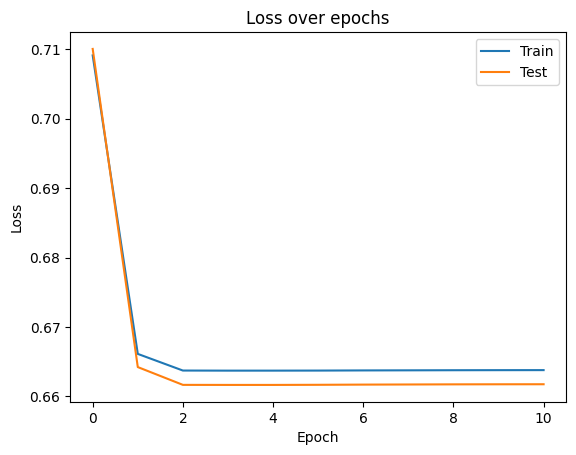

In [16]:
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
#plt.ylim(bottom=0)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
likan.eval()
with torch.no_grad():
    zero = [0, 0]
    one = [0, 0]
    rl = 0.0
    for i in range(len(X_train)):
        y_pred = likan(X_train[i])
        if y_train[i].item() == 1.0:
            one[0] += y_pred.item()
            one[1] += 1
        elif y_train[i].item() == 0.0:
            zero[0] += y_pred.item()
            zero[1] += 1
        loss = criterion(y_pred, y_train[i])
    print('train zero', zero[0]/zero[1])
    print('train one', one[0]/one[1])
    zero = [0, 0]
    one = [0, 0]
    rl = 0.0
    for i in range(len(X_test)):
        y_pred = likan(X_test[i])
        if y_test[i].item() == 1.0:
            one[0] += y_pred.item()
            one[1] += 1
        elif y_test[i].item() == 0.0:
            zero[0] += y_pred.item()
            zero[1] += 1
        loss = criterion(y_pred, y_test[i])
    print('test zero', zero[0]/zero[1])
    print('test one', one[0]/one[1])

train zero 0.4693379755997405
train one 0.4691513724949049
test zero 0.4693283694572795
test one 0.46915672335562225


## Lokaorð
Þetta líkan er ekki nógu gott. Ég reyndi að þjálfa líkanið með 3.000 myndum, en það var of mikið fyrir tölvuna mína.